In [1]:
from __future__ import print_function, division
from keras.datasets import fashion_mnist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K
import scipy

C:\Users\kenneth\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
name = 'fashion_CCGAN'
if not os.path.exists("saved_model/"+name):
        os.mkdir("saved_model/"+name)
if not os.path.exists("images/"+name):
        os.mkdir("images/"+name)

In [3]:
# Download the dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print('X_train', X_train.shape,'y_train', y_train.shape)
print('X_test', X_test.shape,'y_test', y_test.shape)

X_train (60000, 28, 28) y_train (60000,)
X_test (10000, 28, 28) y_test (10000,)


In [4]:
input_classes = pd.Series(y_train).nunique()
input_classes

10

In [5]:
# Training Labels are evenly distributed
Train_label_count = pd.Series(y_train).value_counts()
Train_label_count

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64

In [6]:
# Test Labels are evenly distributed
Test_label_count = pd.Series(y_test).value_counts()
Test_label_count

7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
9    1000
1    1000
8    1000
0    1000
dtype: int64

In [7]:
#label dictionary from documentation
label_dict = {0: 'tshirt',
              1: 'trouser',
              2: 'pullover',
              3: 'dress',
              4: 'coat',
              5: 'sandal',
              6: 'shirt',
              7: 'sneaker',
              8: 'bag',
              9: 'boot'}

In [8]:
X_train[1].shape

(28, 28)

In [9]:
#input dimensions
input_rows = X_train[1][0]
input_cols = X_train[1][1]
input_channels = 1

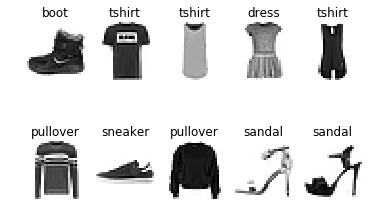

In [10]:
# plot images from the train dataset
for i in range(10):
    # define subplot
    a=plt.subplot(2, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(X_train[i], cmap='gray_r')
    a.set_title(label_dict[y_train[i]])

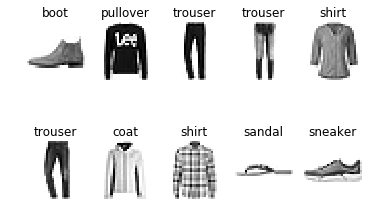

In [11]:
# plot images from the test dataset
for i in range(10):
    # define subplot
    a=plt.subplot(2, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(X_test[i], cmap='gray_r')
    a.set_title(label_dict[y_test[i]])

In [12]:
class CCGAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.mask_height = 10
        self.mask_width = 10
        self.num_classes = 10

        # Number of filters in first layer of generator and discriminator
        self.gf = 32
        self.df = 32

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['mse', 'categorical_crossentropy'],
            loss_weights=[0.5, 0.5],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        masked_img = Input(shape=self.img_shape)
        gen_img = self.generator(masked_img)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid, _ = self.discriminator(gen_img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(masked_img , valid)
        self.combined.compile(loss=['mse'],
            optimizer=optimizer)


    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        img = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(img, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)

        # Upsampling
        u1 = deconv2d(d4, d3, self.gf*4)
        u2 = deconv2d(u1, d2, self.gf*2)
        u3 = deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

        return Model(img, output_img)

    def build_discriminator(self):

        img = Input(shape=self.img_shape)

        model = Sequential()
        model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.8))
        model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(InstanceNormalization())
        model.add(Conv2D(256, kernel_size=4, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(InstanceNormalization())

        model.summary()

        img = Input(shape=self.img_shape)
        features = model(img)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(features)

        label = Flatten()(features)
        label = Dense(self.num_classes+1, activation="softmax")(label)

        return Model(img, [validity, label])

    def mask_randomly(self, imgs):
        y1 = np.random.randint(0, self.img_rows - self.mask_height, imgs.shape[0])
        y2 = y1 + self.mask_height
        x1 = np.random.randint(0, self.img_rows - self.mask_width, imgs.shape[0])
        x2 = x1 + self.mask_width

        masked_imgs = np.empty_like(imgs)
        for i, img in enumerate(imgs):
            masked_img = img.copy()
            _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i],
            masked_img[_y1:_y2, _x1:_x2, :] = 0
            masked_imgs[i] = masked_img

        return masked_imgs


    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
        # Rescale MNIST to 32x32
        X_train = np.array([scipy.misc.imresize(x, [self.img_rows, self.img_cols]) for x in X_train])

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 4, 4, 1))
        fake = np.zeros((batch_size, 4, 4, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Sample half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            labels = y_train[idx]

            masked_imgs = self.mask_randomly(imgs)

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(masked_imgs)

            # One-hot encoding of labels
            labels = to_categorical(labels, num_classes=self.num_classes+1)
            fake_labels = to_categorical(np.full((batch_size, 1), self.num_classes), num_classes=self.num_classes+1)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, labels])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator
            g_loss = self.combined.train_on_batch(masked_imgs, valid)

            # Plot the progress
            #print ("%d [D loss: %f, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[4], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                # Select a random half batch of images
                idx = np.random.randint(0, X_train.shape[0], 6)
                imgs = X_train[idx]
                self.sample_images(epoch, imgs)
                self.save_model()
                print ("%d [D loss: %f, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[4], g_loss))

    def sample_images(self, epoch, imgs):
        r, c = 3, 6

        masked_imgs = self.mask_randomly(imgs)
        gen_imgs = self.generator.predict(masked_imgs)

        imgs = (imgs + 1.0) * 0.5
        masked_imgs = (masked_imgs + 1.0) * 0.5
        gen_imgs = (gen_imgs + 1.0) * 0.5

        gen_imgs = np.where(gen_imgs < 0, 0, gen_imgs)

        fig, axs = plt.subplots(r, c)
        for i in range(c):
            axs[0,i].imshow(imgs[i, :, :, 0], cmap='gray')
            axs[0,i].axis('off')
            axs[1,i].imshow(masked_imgs[i, :, :, 0], cmap='gray')
            axs[1,i].axis('off')
            axs[2,i].imshow(gen_imgs[i, :, :, 0], cmap='gray')
            axs[2,i].axis('off')
        fig.savefig("images/"+name+"/_%d.png" % epoch)
        plt.imread("images/"+name+"/_%d.png" % epoch)
        plt.show()
        plt.close()

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/"+name+"/%s.json" % model_name
            weights_path = "saved_model/"+name+"/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])
        save(self.generator, "ccgan_generator")
        save(self.discriminator, "ccgan_discriminator")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        1088      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
instance_normalization_1 (In (None, 8, 8, 128)         2         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         524544    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4, 4, 256)         0         
__________

C:\Users\kenneth\Anaconda3\lib\site-packages\ipykernel\__main__.py:130: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\kenneth\Anaconda3\lib\site-packages\keras\engine\training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


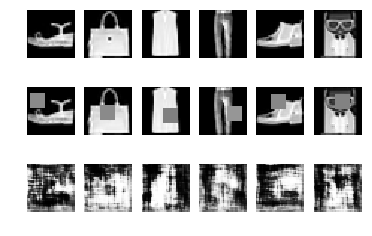

0 [D loss: 3.925248, op_acc: 12.50%] [G loss: 1.425184]


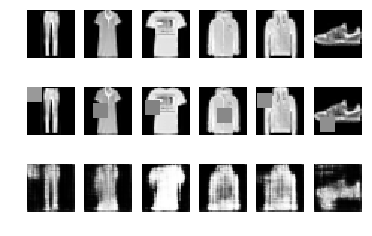

100 [D loss: 0.539166, op_acc: 73.44%] [G loss: 0.551123]


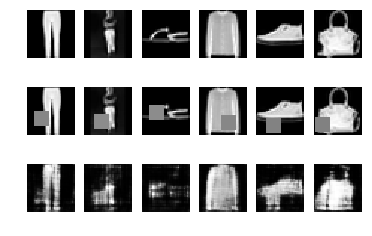

200 [D loss: 0.395278, op_acc: 92.19%] [G loss: 0.474145]


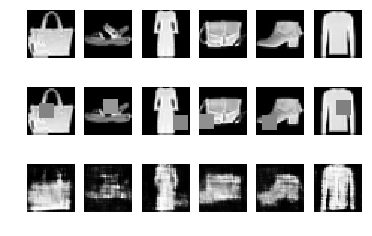

300 [D loss: 0.416045, op_acc: 76.56%] [G loss: 0.415518]


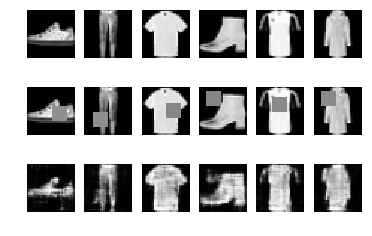

400 [D loss: 0.448418, op_acc: 79.69%] [G loss: 0.417873]


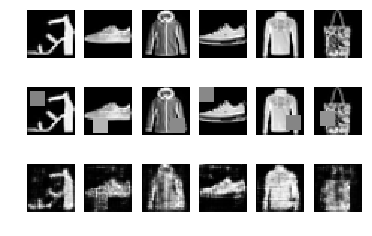

500 [D loss: 0.413164, op_acc: 81.25%] [G loss: 0.372868]


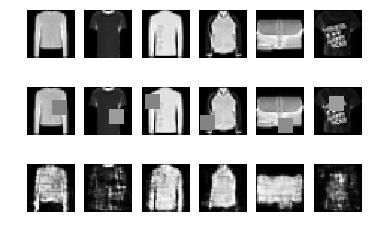

600 [D loss: 0.322172, op_acc: 90.62%] [G loss: 0.377251]


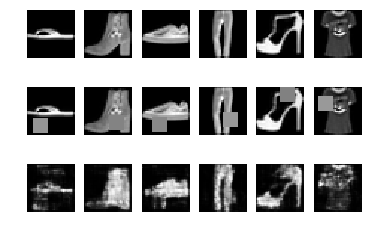

700 [D loss: 0.435321, op_acc: 84.38%] [G loss: 0.357748]


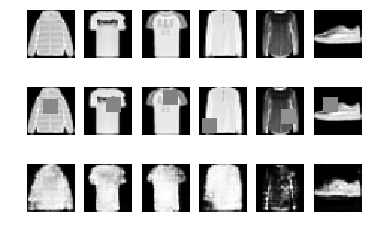

800 [D loss: 0.346423, op_acc: 89.06%] [G loss: 0.442021]


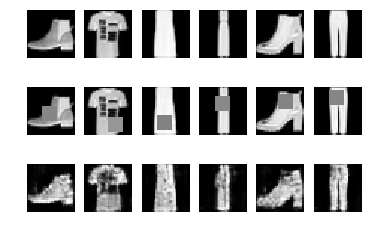

900 [D loss: 0.354583, op_acc: 89.06%] [G loss: 0.433286]


In [13]:
ccgan = CCGAN()
ccgan.train(epochs=1000, batch_size=32, sample_interval=100)